In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns, warnings

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family='NanumGothic')
rc('font', family=font_name)
mpl.rcParams['axes.unicode_minus'] = False

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

warnings.filterwarnings(action='ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [2]:
df_raw = pd.read_csv('cl1.csv')

In [3]:
df = df_raw
df.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV
0,201901,제주,정기 항공 운송업,20s,1,1,1745,316307962,1728,0
1,201901,제주,정기 항공 운송업,20s,1,2,134,26026742,144,0
2,201901,제주,정기 항공 운송업,20s,2,1,2250,395638789,2293,0
3,201901,제주,정기 항공 운송업,20s,2,2,309,53189601,295,0
4,201901,제주,정기 항공 운송업,30s,1,1,254,49299528,268,0


# Data Preprocessing

In [4]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [5]:
df['year'] = df['REG_YYMM'].apply(lambda x: grap_year(x))
df['month'] = df['REG_YYMM'].apply(lambda x: grap_month(x))
df = df.drop(['REG_YYMM'], axis=1)

In [6]:
def make_season(data):
    if data in [12, 1, 2]:
        return 'Winter'
    elif data in [3, 4, 5]:
        return 'Spring'
    elif data in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [7]:
df['Season'] = df['month'].apply(lambda x: make_season(x))

In [8]:
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,CV,year,month,Season
0,제주,정기 항공 운송업,20s,1,1,1745,316307962,1728,0,2019,1,Winter
1,제주,정기 항공 운송업,20s,1,2,134,26026742,144,0,2019,1,Winter
2,제주,정기 항공 운송업,20s,2,1,2250,395638789,2293,0,2019,1,Winter
3,제주,정기 항공 운송업,20s,2,2,309,53189601,295,0,2019,1,Winter
4,제주,정기 항공 운송업,30s,1,1,254,49299528,268,0,2019,1,Winter


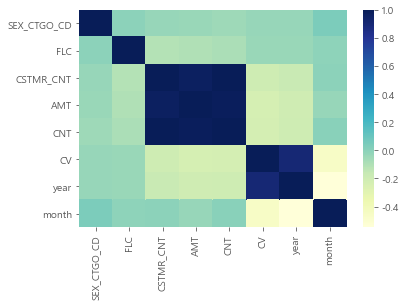

In [9]:
sns.heatmap(df.corr(),cmap='YlGnBu',fmt='.1g')

# Label Encoding

In [10]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df[column] = encoder.transform(df[column])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421 entries, 0 to 420
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   CARD_SIDO_NM  421 non-null    int32
 1   STD_CLSS_NM   421 non-null    int32
 2   AGE           421 non-null    int32
 3   SEX_CTGO_CD   421 non-null    int64
 4   FLC           421 non-null    int64
 5   CSTMR_CNT     421 non-null    int64
 6   AMT           421 non-null    int64
 7   CNT           421 non-null    int64
 8   CV            421 non-null    int64
 9   year          421 non-null    int64
 10  month         421 non-null    int64
 11  Season        421 non-null    int32
dtypes: int32(4), int64(8)
memory usage: 33.0 KB


In [12]:
df.STD_CLSS_NM.unique()

array([1, 0])

In [13]:
df['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

# Preprocessing

In [14]:
# 변수명 지정
X_cols = list(df.columns)
X_cols.remove('AMT')

In [15]:
X = df.drop(['AMT'], axis=1)
y = np.log1p(df['AMT'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [17]:
X_train

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,CNT,CV,year,month,Season
64,0,1,3,2,4,175,175,0,2019,3,1
316,0,1,2,1,2,2565,2794,0,2019,12,3
152,0,1,1,1,2,195,193,0,2019,7,2
112,0,1,3,2,3,1758,1858,0,2019,5,1
384,0,1,3,1,4,126,109,2,2020,2,3
...,...,...,...,...,...,...,...,...,...,...,...
146,0,0,1,2,1,15,17,0,2019,7,2
106,0,1,2,2,2,3309,3213,0,2019,5,1
310,0,0,4,2,4,3,3,0,2019,12,3
205,0,1,5,1,5,855,915,0,2019,8,2


# Stacking

In [59]:
rf = RandomForestRegressor(max_depth=8, max_features='auto', n_estimators=300)
rf.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(rf.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(rf.score(X_test,y_test)))

Score on training set : 0.981
Score on test set : 0.947


In [60]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)
# Train 데이터 설명력
print("Score on training set : {:.3f}".format(gb.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(gb.score(X_test,y_test)))

Score on training set : 0.982
Score on test set : 0.966


In [62]:
estimators = [('rf', RandomForestRegressor(n_estimators=300)),
              ('gb', GradientBoostingRegressor(n_estimators=300))]

In [63]:
# build model
Stacking_Model = StackingRegressor(estimators=estimators)

labels = y_train
features = X_train

# Fit the RF model with features and labels.
st_reg=Stacking_Model.fit(features, labels)

In [64]:
print("Score on training set : {:.3f}".format(st_reg.score(X_train,y_train)))
print("Score on test set : {:.3f}".format(st_reg.score(X_test,y_test)))

Score on training set : 0.996
Score on test set : 0.983


In [65]:
# 모델 실행 및 결과 확인
X_test_predict=pd.DataFrame(
    st_reg.predict(X_test)).rename(
    columns={0:'predict'})
X_train_predict=pd.DataFrame(
    st_reg.predict(X_train)).rename(
    columns={0:'predict'})

# combine the training and testing dataframes to visualize
# and compare.
SR_predict = X_train_predict.append(X_test_predict)

In [66]:
np.sqrt(mean_squared_error(y_test, st_reg.predict(X_test)))

0.27342919971973284

In [67]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
Seasons = df['Season'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for AGE in AGEs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                    for year in years:
                        for month in months:
                            for Season in Seasons:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC, year, month, Season])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'Season'])

In [68]:
df2 = df[(df['year']==2020) & (df['month']==2)]
df3 = df[(df['year']==2020) & (df['month']==3)]
df4 = pd.concat([df2, df3], axis=0)

In [69]:
df4.drop(['AMT', 'year', 'month', 'Season'], axis=1, inplace=True)

In [70]:
temp = pd.merge(temp, df4, on=['CARD_SIDO_NM','STD_CLSS_NM','AGE','SEX_CTGO_CD','FLC'])

In [71]:
# 예측
pred = st_reg.predict(temp)
pred = np.expm1(pred)

In [72]:
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [73]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감량'] = (v['4월'] - v['3월']) / v['3월'] * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감량
0,그외 기타 종합 소매업,1.106142e+10,40433017255,-72.642617
1,기타 외국식 음식점업,4.807695e+09,7348439049,-34.575284
2,기타음식료품위주종합소매업,6.849142e+09,25422139867,-73.058356
3,버스 운송업,3.409655e+09,2798198940,21.851779
4,빵 및 과자류 소매업,3.118725e+09,14350083255,-78.266848
5,스포츠 및 레크레이션 용품 임대업,1.572997e+10,13713309096,14.705882
6,육류 소매업,7.082820e+09,16014475439,-55.772391
7,일식 음식점업,7.842592e+09,14155708402,-44.597674
8,정기 항공 운송업,2.520524e+10,2284378045,1003.374452
9,중식 음식점업,5.358297e+09,13327780001,-59.796027


# Light Gradient Boosting Machine

In [18]:
import lightgbm as lgb

In [19]:
train_ds = lgb.Dataset(X_train, label=y_train)
val_ds = lgb.Dataset(X_test, label=y_test)

In [20]:
params = {
            'learning_rate' : 0.1,
            'boosting_type': 'gbdt',
            'objective': 'tweedie',
            'tweedie_variance_power': 1.1,
            'metric': 'rmse',
            'sub_row' : 0.75,
            'lambda_l2' : 0.1        }

In [21]:
model = lgb.train(params,
                  train_ds,
                  5000,
                  val_ds,
                  verbose_eval = 100,
                  early_stopping_rounds = 100
                 )

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.425768
Early stopping, best iteration is:
[53]	valid_0's rmse: 0.411955


# Template

In [22]:
X.columns

Index(['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'CSTMR_CNT',
       'CNT', 'CV', 'year', 'month', 'Season'],
      dtype='object')

In [50]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = df['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df['STD_CLSS_NM'].unique()
AGEs          = df['AGE'].unique()
SEX_CTGO_CDs  = df['SEX_CTGO_CD'].unique()
FLCs          = df['FLC'].unique()
Seasons = df['Season'].unique()
years         = [2020]
months        = [4, 7]

temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for AGE in AGEs:
            for SEX_CTGO_CD in SEX_CTGO_CDs:
                for FLC in FLCs:
                    for year in years:
                        for month in months:
                            for Season in Seasons:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM, AGE, SEX_CTGO_CD, FLC, year, month, Season])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=['CARD_SIDO_NM', 'STD_CLSS_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month', 'Season'])

In [51]:
temp

,CARD_SIDO_NM,STD_CLSS_NM,AGE,SEX_CTGO_CD,FLC,year,month,Season
0,0,1,1,1,1,2020,4,3
1,0,1,1,1,1,2020,4,1
2,0,1,1,1,1,2020,4,2
3,0,1,1,1,1,2020,4,0
4,0,1,1,1,1,2020,7,3
...,...,...,...,...,...,...,...,...
1115,0,0,0,2,5,2020,4,0
1116,0,0,0,2,5,2020,7,3
1117,0,0,0,2,5,2020,7,1
1118,0,0,0,2,5,2020,7,2


In [52]:
df2 = df[(df['year']==2020) & (df['month']==3)]
df3 = df[(df['year']==2020) & (df['month']==3)]
df4 = pd.concat([df2, df3], axis=0)

In [53]:
df4.drop(['AMT', 'year', 'month', 'Season'], axis=1, inplace=True)

In [54]:
temp = pd.merge(temp, df4, on=['CARD_SIDO_NM','STD_CLSS_NM','AGE','SEX_CTGO_CD','FLC'])

In [55]:
# 예측
pred = model.predict(temp)
pred = np.expm1(pred)

In [56]:
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [57]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [58]:
v = pd.merge(temp[temp['REG_YYMM']==202004],df_raw[df_raw['REG_YYMM']==202003].groupby(['STD_CLSS_NM'])[['AMT']].sum().reset_index(), on=['STD_CLSS_NM'])
v = v.drop(['REG_YYMM', 'CARD_SIDO_NM'], axis=1)
v = v.rename(columns={'AMT_x' : '4월', 'AMT_y' : '3월'})
v['3월 대비 증감률'] = (v['4월'] - v['3월']) / v['3월'] * 100
v

,STD_CLSS_NM,4월,3월,3월 대비 증감률
0,그외 기타 분류안된 오락관련 서비스업,2797616.0,313500,792.381499
1,정기 항공 운송업,139730924.0,199721907,-30.037257


In [61]:
temp.to_csv('./template1.csv',index=False, encoding='utf-8-sig')